In [2]:
seed = 5
import sys
import os
# Add the project root directory to the Python path
from model.fully_connected_trivial_net import FullyConnectedTrivialNet
# numpy==1.24.1
import numpy as np
# torch==2.1.0
import torch

torch.manual_seed(seed)
np.random.seed(seed)

In [19]:

n_timesteps, n_assets = 2000, 5
lookback, gap, horizon = 40, 2, 10

n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))
# endblock
import numpy as np


def sin_single(n_timesteps, amplitude = 1, freq = 0.25, phase = 0):
    x = np.arange(n_timesteps)
    return amplitude * np.sin(2 * np.pi * freq * x + phase)


Mean returns: 0.0001


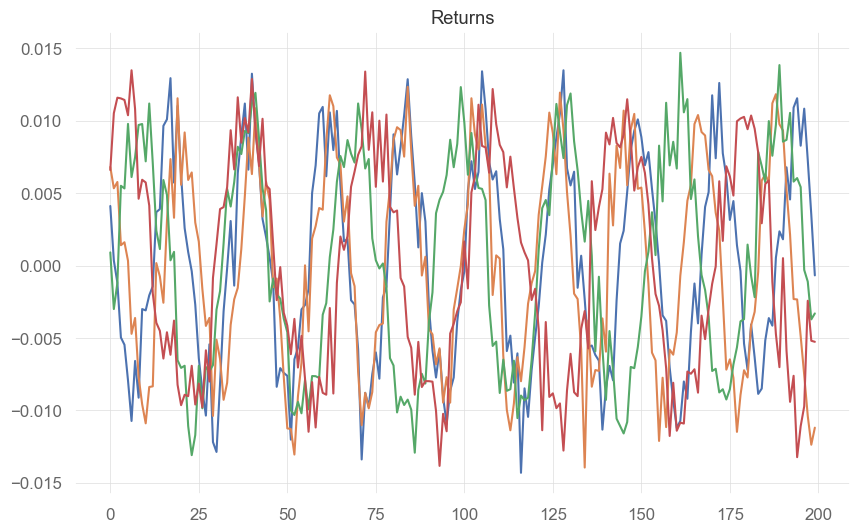

In [20]:

returns = np.array(
    [
        sin_single(
            n_timesteps,
            freq = 1 / np.random.randint(3, lookback),
            amplitude = 0.01,
            phase = np.random.randint(0, lookback)
        ) for _ in range(n_assets)
    ]
).T

# We also add some noise.
returns += np.random.normal(scale = 0.002, size = returns.shape)

# Mean returns
print(f'Mean returns: {round(sum(np.mean(returns, axis = 0)), 5)}')
# Mean returns: 0.00013

# Plot returns
# matplotlib==3.7.2
import matplotlib.pyplot as plt

plt.title('Returns')
plt.plot(returns[:200, 0:(n_assets - 1)])
plt.show()

In [21]:
returns

array([[ 0.00410833,  0.00680279,  0.00090697,  0.0065949 , -0.0080139 ],
       [ 0.0003504 ,  0.00533049, -0.00300244,  0.0105141 , -0.00433254],
       [-0.00118769,  0.00576621, -0.00119775,  0.0115836 , -0.00027665],
       ...,
       [ 0.0091484 ,  0.00545557, -0.00461006,  0.01008246,  0.00436514],
       [ 0.0112598 ,  0.00483259, -0.00724074,  0.0113225 ,  0.00704511],
       [ 0.01178678,  0.00015033, -0.00556561,  0.0108725 ,  0.00768195]])

In [5]:

# Creating sliding window sets
X_list, y_list = [], []

for i in range(lookback, n_timesteps - horizon - gap + 1):
    X_list.append(returns[i - lookback: i, :])
    y_list.append(returns[i + gap: i + gap + horizon, :])

X = np.stack(X_list, axis = 0)[:, None, ...]
y = np.stack(y_list, axis = 0)[:, None, ...]

print(f'X: {X.shape}, y: {y.shape}')

X: (1949, 1, 40, 5), y: (1949, 1, 10, 5)


In [6]:

from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale

means, stds = prepare_standard_scaler(X, indices = indices_train)
dataset = InRAMDataset(X, y, transform = Scale(means, stds))

batch_size = 512
dataloader_train = RigidDataLoader(
    dataset,
    indices = indices_train,
    batch_size = batch_size
)

dataloader_test = RigidDataLoader(
    dataset,
    indices = indices_test,
    batch_size = batch_size
)

In [7]:

from model.fully_connected_trivial_net import FullyConnectedTrivialNet

network = FullyConnectedTrivialNet(n_assets, lookback)
network = network.train()

In [8]:

from deepdow.losses import SharpeRatio
from torch.optim import Adam

loss = SharpeRatio()
optimizer = Adam(network.parameters(), amsgrad = True)

train_epochs = 10
print('Training...')
for epoch in range(train_epochs):
    error_list = []
    for batch_idx, batch in enumerate(dataloader_train):
        X_batch, y_batch, timestamps, asset_names = batch

        X_batch = X_batch.float()
        y_batch = y_batch.float()

        weights = network(X_batch)
        error = loss(weights, y_batch).mean()
        error_list.append(error.item())
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
    print(f'Epoch {epoch} | Error: {round(np.mean(error_list), 5)}')

Training...
Epoch 0 | Error: -0.58382
Epoch 1 | Error: -0.80179
Epoch 2 | Error: -1.03625
Epoch 3 | Error: -1.36138
Epoch 4 | Error: -1.34441
Epoch 5 | Error: -1.38109
Epoch 6 | Error: -1.35753
Epoch 7 | Error: -1.53847
Epoch 8 | Error: -1.52779
Epoch 9 | Error: -1.6361


In [9]:

network = network.eval()

# Weights for the test set
weights_list = []
timestamps_list = []
for X_batch, _, timestamps, _ in dataloader_test:
    X_batch = X_batch.float()
    weights = network(X_batch).detach().numpy()

    weights_list.append(weights)
    timestamps_list.extend(timestamps)

weights = np.concatenate(weights_list, axis = 0)
asset_names = [dataloader_test.dataset.asset_names[asset_ix] for asset_ix in dataloader_test.asset_ixs]

# pandas==1.5.3
import pandas as pd

weights_df = pd.DataFrame(
    weights,
    index = timestamps_list,
    columns = asset_names
)
weights_df.sort_index(inplace = True)

In [14]:
weights_df

,a_0,a_1,a_2,a_3,a_4
1609,0.054826,0.062339,0.023237,0.060181,0.799416
1610,0.079075,0.032609,0.033596,0.121057,0.733663
1611,0.060867,0.015920,0.039702,0.234431,0.649080
1612,0.048907,0.007578,0.072027,0.455555,0.415932
1613,0.026514,0.005596,0.091718,0.700304,0.175868
...,...,...,...,...,...
1944,0.013706,0.400393,0.130417,0.439138,0.016346
1945,0.009073,0.425377,0.065099,0.480631,0.019819
1946,0.015374,0.457673,0.046406,0.449298,0.031248
1947,0.018227,0.393706,0.032289,0.479448,0.076330


In [10]:

# Multiply the returns by the weights to get the portfolio returns.
# returns_df - empty DataFrame for storing portfolio returns with same index as weights_df
model_returns_df, uniform_returns_df = pd.DataFrame(), pd.DataFrame()
model_returns_df.index, uniform_returns_df.index = weights_df.index, weights_df.index

uniform_weights = np.ones(n_assets) / n_assets
for idx in range(indices_test[0], indices_test[-1] - gap - horizon, horizon):
    i_model_returns = (np.array(weights_df.loc[idx].tolist()) * returns[idx + gap: idx + gap + horizon]).sum(axis = 1)
    i_uniform_returns = (uniform_weights * returns[idx + gap: idx + gap + horizon]).sum(axis = 1)
    # Store the returns in the DataFrame to range [idx + gap: idx + gap + horizon]
    model_returns_df.loc[idx + gap: idx + gap + len(i_model_returns) - 1, 'return'] = i_model_returns
    uniform_returns_df.loc[idx + gap: idx + gap + len(i_uniform_returns) - 1, 'return'] = i_uniform_returns

# Drop the NaN values from the DataFrame.
model_returns_df.dropna(inplace = True)
uniform_returns_df.dropna(inplace = True)

## Model Results for Synthetic Variational Allocation


- **Sharpe Ratio**: 6.5881
- **CAGR**: 0.6460
- **Max Drawdown**: -0.0345


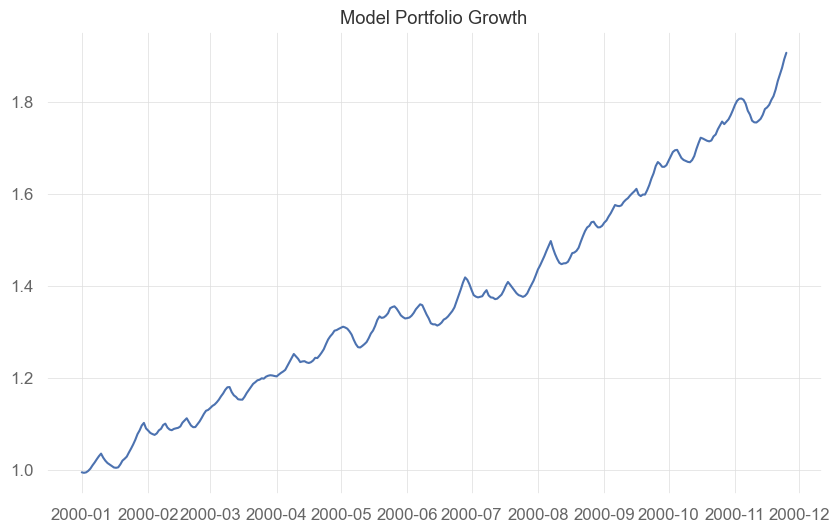

## Uniform Results for Synthetic Variational Allocation


- **Sharpe Ratio**: 0.0568
- **CAGR**: 0.0016
- **Max Drawdown**: -0.0589


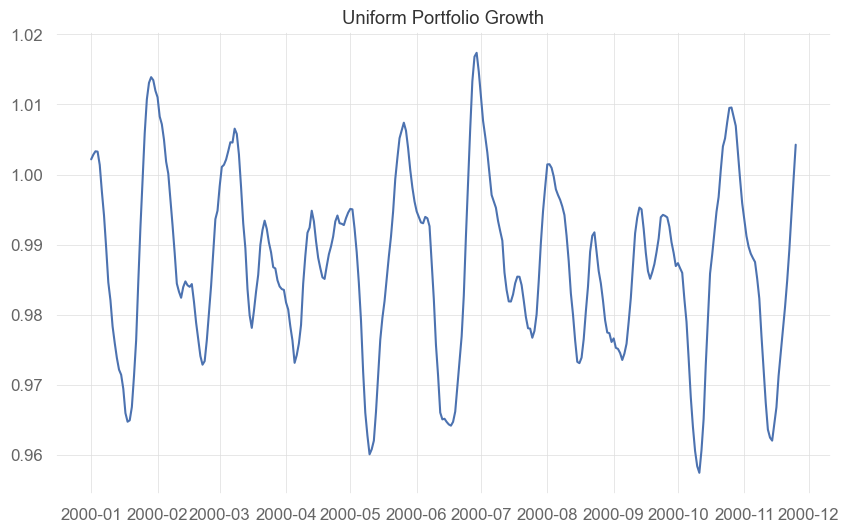

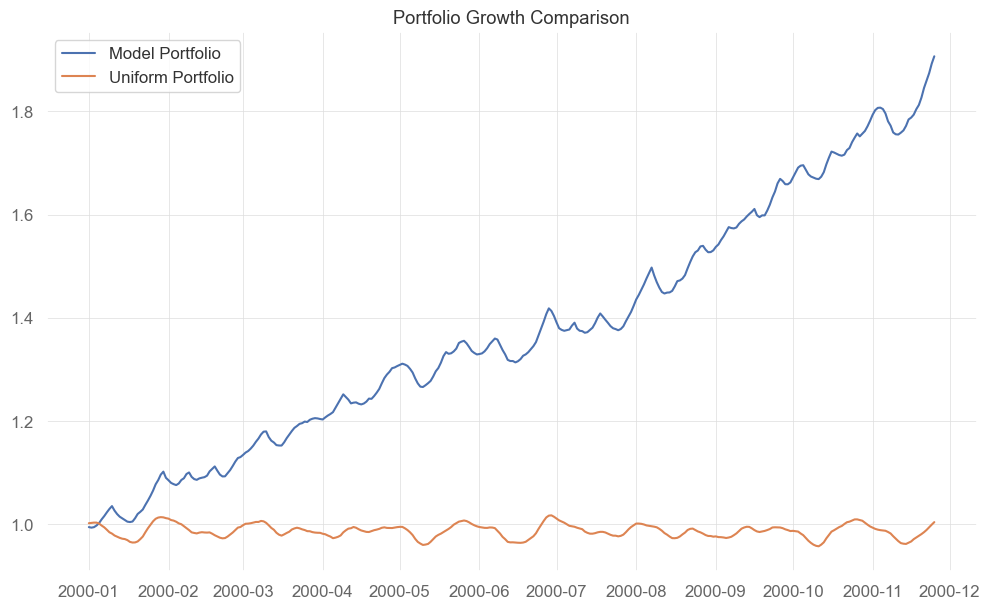

In [11]:

import os
# QuantStats==0.0.62
import quantstats as qs

model_balance_df = (model_returns_df['return'] + 1).cumprod()
uniform_balance_df = (uniform_returns_df['return'] + 1).cumprod()

# Adding index to the balance_df as days from 2000-01-01
model_balance_df.index = pd.date_range(start = '2000-01-01', periods = len(model_balance_df))
uniform_balance_df.index = pd.date_range(start = '2000-01-01', periods = len(uniform_balance_df))
# Replace the HTML file generation with inline Jupyter display
from IPython.display import display, HTML, Markdown
import matplotlib.pyplot as plt

# Display Model Results
display(Markdown("## Model Results for Synthetic Variational Allocation"))

# Basic metrics
sharpe = qs.stats.sharpe(model_balance_df)
cagr = qs.stats.cagr(model_balance_df)
max_dd = qs.stats.max_drawdown(model_balance_df)

metrics_html = f"""
- **Sharpe Ratio**: {sharpe:.4f}
- **CAGR**: {cagr:.4f}
- **Max Drawdown**: {max_dd:.4f}
"""
display(Markdown(metrics_html))

# Add a chart using matplotlib and display it directly
plt.figure(figsize=(10, 6))
plt.plot(model_balance_df)
plt.title('Model Portfolio Growth')
plt.show()

# Display Uniform Results
display(Markdown("## Uniform Results for Synthetic Variational Allocation"))

# Basic metrics
sharpe = qs.stats.sharpe(uniform_balance_df)
cagr = qs.stats.cagr(uniform_balance_df)
max_dd = qs.stats.max_drawdown(uniform_balance_df)

metrics_html = f"""
- **Sharpe Ratio**: {sharpe:.4f}
- **CAGR**: {cagr:.4f}
- **Max Drawdown**: {max_dd:.4f}
"""
display(Markdown(metrics_html))

# Add a chart and display it directly
plt.figure(figsize=(10, 6))
plt.plot(uniform_balance_df)
plt.title('Uniform Portfolio Growth')
plt.show()

# You can also display a comparison plot
plt.figure(figsize=(12, 7))
plt.plot(model_balance_df, label='Model Portfolio')
plt.plot(uniform_balance_df, label='Uniform Portfolio')
plt.title('Portfolio Growth Comparison')
plt.legend()
plt.grid(True)
plt.show()
